<a href="https://colab.research.google.com/github/Rohit-Singh12/Deep-LEARGNINGS/blob/main/Misc/Model%20Compression/KnowledgeDistillation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Knowledge Distillation Demo

Knowledge distillation is one way of doing model compression. Here
we train the model as we would focusing completely on the training and model
optimization. After that we train a smaller model to follow output distribution
of the bigger model which is called Teacher model and the smaller model is called Student Model

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [2]:
tranform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### We will use MNIST dataset for the Demo.

In [6]:
trainset = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=tranform
)

train_loader = DataLoader(trainset, batch_size=64, shuffle=True)

In [7]:
testset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1325,), (0.3105,))
    ])
)
test_loader = DataLoader(testset, batch_size=64, shuffle=True)

In [8]:
img,label = next(iter(train_loader))
img.shape, label.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [9]:
input_shape=(28,28)

### First train the Smaller model and check it performance.

In [11]:
class NormalModel(nn.Module):
  def __init__(self):
    super(NormalModel, self).__init__()
    self.fc1 = nn.Linear(input_shape[0]*input_shape[1], 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, input):
    input = input.view(input.size()[0], -1)
    X = F.relu(self.fc1(input))
    return self.fc2(X)


In [12]:
basic_model = NormalModel().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(basic_model.parameters(), lr=0.001)

In [42]:
def evaluate(test_model):
  test_model.eval()
  correct, total = 0,0
  with torch.no_grad():
    for images, labels in test_loader:
      logits = test_model(images.to(device))
      y_hat = torch.argmax(logits, dim=1)
      total += label.size(0)
      correct += (y_hat == labels.to(device)).sum().item()

  print(f"Test Accuracy {100*correct/total:.2f}%")

In [43]:
n_epochs = 5
for epoch in range(n_epochs):
  basic_model.train()

  running_loss = 0.0
  for images, labels in train_loader:
    optimizer.zero_grad()
    y_hat = basic_model(images.to(device))
    loss = loss_fn(y_hat, labels.to(device))
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  print(f"Epoch [{epoch+1}/{n_epochs}] {evaluate(basic_model)}")


Test Accuracy 95.25%
Epoch [1/5] None
Test Accuracy 96.52%
Epoch [2/5] None
Test Accuracy 96.88%
Epoch [3/5] None
Test Accuracy 97.41%
Epoch [4/5] None
Test Accuracy 97.13%
Epoch [5/5] None


## Use CNN for image classification

Now train the bigger and better model

In [13]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=3, stride=1)#[batch, 32, 26, 26]
    self.fc1 = nn.Linear(32*26*26, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, input):
    X = F.relu(self.conv(input))
    X = self.pool(X)
    X = X.view(X.size(0), -1)
    X = F.relu(self.fc1(X))
    return self.fc2(X)

### Conclusion
As we can see the complexity of CNN model is model and also its performance is better than Basic Neural Network

In [46]:
n_epochs = 5
cnn_model = CNN().to(device)
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
for epoch in range(n_epochs):
  cnn_model.train()

  for images, labels in train_loader:
    optimizer.zero_grad()
    y_hat = cnn_model(images.to(device))
    loss = loss_fn(y_hat, labels.to(device))
    loss.backward()
    optimizer.step()
  print(f"Epoch [{epoch+1}/{n_epochs}] {evaluate(cnn_model)}")


Test Accuracy 96.58%
Epoch [1/5] None
Test Accuracy 97.80%
Epoch [2/5] None
Test Accuracy 97.69%
Epoch [3/5] None
Test Accuracy 98.13%
Epoch [4/5] None
Test Accuracy 98.35%
Epoch [5/5] None


Now we will use knowledge distillation to train the Basic Neural Network (Student Model) to follow Teacher Model (CNN Model)

## Use Knowledge distillation to train the Basic Model

## KL Divergence
KL divergence is used to quantify how similar two distributions are. If the value of KL Divergence is high that means the two distributions are different.
Its defined as:
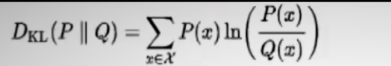


In [47]:
def KL_divergence(teacher_logits, student_logits):
  p_teacher = F.softmax(teacher_logits, dim=1)
  p_student = F.log_softmax(student_logits, dim=1)
  loss = F.kl_div(p_student, p_teacher, reduction='batchmean')
  return loss

In [49]:
student_model = NormalModel().to(device)
optimizer = torch.optim.Adam(student_model.parameters(), lr=0.001)
for epoch in range(5):
    student_model.train()

    for images, labels in train_loader:
      optimizer.zero_grad()
      student_logits = student_model(images.to(device))
      teacher_logits = cnn_model(images.to(device)).detach()
      # print(student_logits.shape, teacher_logits.shape)
      loss = KL_divergence(student_logits, teacher_logits)
      loss.backward()
      optimizer.step()
    print(f"Epoch [{epoch+1}/{n_epochs}] {evaluate(cnn_model)}")


Test Accuracy 98.35%
Epoch [1/5] None
Test Accuracy 98.35%
Epoch [2/5] None
Test Accuracy 98.35%
Epoch [3/5] None
Test Accuracy 98.35%
Epoch [4/5] None
Test Accuracy 98.35%
Epoch [5/5] None


Its cearly visible that the Accuracy of the Student model is same as Teacher model with less model complexity